In [39]:
import pandas as pd

churn= pd.read_csv(f"final_churn_data.csv")

In [40]:
X = churn.drop('Exited', axis=1)
y = churn['Exited']


In [41]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Stratified split ensures both classes appear in train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,          # ✅ critical line
    random_state=42
)

# Apply SMOTE safely
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score



In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("🔹 Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


🔹 Random Forest Results:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.80      0.46      0.59       404

    accuracy                           0.87      1997
   macro avg       0.84      0.72      0.75      1997
weighted avg       0.86      0.87      0.85      1997

ROC-AUC: 0.8530521837494485


In [44]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Get predicted probabilities
y_proba = rf.predict_proba(X_test)[:, 1]

# Set new threshold
threshold = 0.4
y_pred_new = np.where(y_proba >= threshold, 1, 0)

# Evaluate again
print(classification_report(y_test, y_pred_new))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# Optional: check confusion matrix
print(confusion_matrix(y_test, y_pred_new))


              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1593
           1       0.67      0.54      0.60       404

    accuracy                           0.85      1997
   macro avg       0.78      0.74      0.75      1997
weighted avg       0.84      0.85      0.85      1997

ROC-AUC: 0.8530521837494485
[[1483  110]
 [ 184  220]]


In [45]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_proba = rf.predict_proba(X_test)[:, 1]
y_pred_threshold = np.where(y_proba >= 0.4, 1, 0)

print(classification_report(y_test, y_pred_threshold))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred_threshold))


              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1593
           1       0.67      0.54      0.60       404

    accuracy                           0.85      1997
   macro avg       0.78      0.74      0.75      1997
weighted avg       0.84      0.85      0.85      1997

ROC-AUC: 0.8530521837494485
[[1483  110]
 [ 184  220]]


In [46]:
import pandas as pd
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances.head(10))


                          Feature  Importance
2                             Age    0.151196
5                   NumOfProducts    0.102239
13                CreditScore_Age    0.099621
16  NumOfProducts_EstimatedSalary    0.085072
0                     CreditScore    0.070179
8                 EstimatedSalary    0.066929
4                         Balance    0.063455
12                    TenureByAge    0.062149
11             BalanceSalaryRatio    0.051878
14        Balance_EstimatedSalary    0.051637


In [49]:
churn['Risk'] = np.where((churn['CreditScore'] < 700) | (churn['Balance'] < 100000), 1, 0)
print(churn['Risk'].value_counts())


Risk
1    8474
0    1511
Name: count, dtype: int64


In [50]:
from sklearn.model_selection import train_test_split

# Choose useful features for prediction
X = churn[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'IsActiveMember', 'Tenure']]
y = churn['Risk']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [52]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

c:\Users\ENVY\OneDrive\Desktop\Financial_Risk_and_Customer_Retention\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


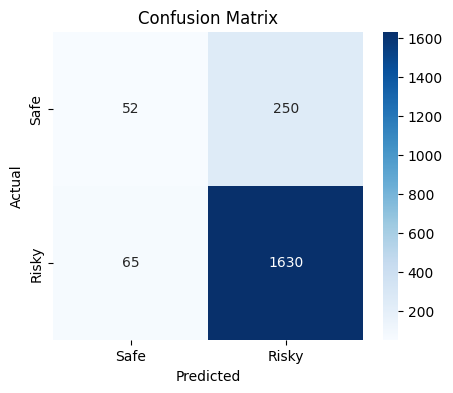

              precision    recall  f1-score   support

           0       0.44      0.17      0.25       302
           1       0.87      0.96      0.91      1695

    accuracy                           0.84      1997
   macro avg       0.66      0.57      0.58      1997
weighted avg       0.80      0.84      0.81      1997



In [53]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe', 'Risky'], yticklabels=['Safe', 'Risky'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(y_test, y_pred))


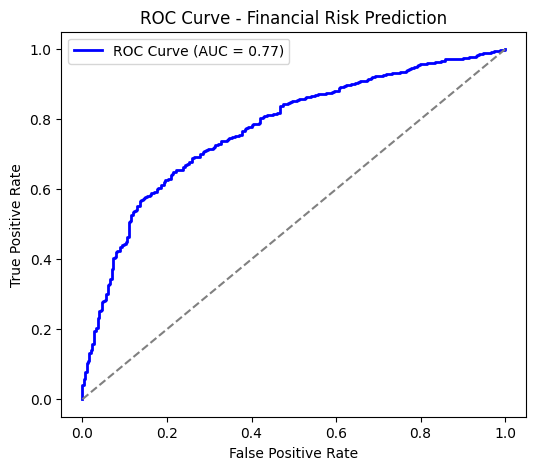

In [54]:
# Predict probabilities
y_prob = model.predict_proba(X_test)[:,1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Financial Risk Prediction")
plt.legend()
plt.show()


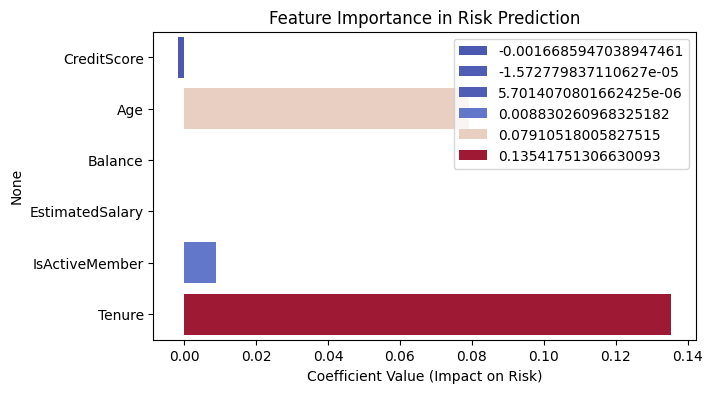

In [56]:
importance = model.coef_[0]
features = X.columns

plt.figure(figsize=(7,4))
sns.barplot(x=importance, y=features, palette="coolwarm",hue=importance)
plt.title("Feature Importance in Risk Prediction")
plt.xlabel("Coefficient Value (Impact on Risk)")
plt.show()
